In [1]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K 
import math

In [2]:
train_x = []
train_y = []
eval_x = []
eval_y = []

In [6]:
csv_path = os.getcwd() + '/fer2013.csv'
with open(csv_path) as f:
    for line in tqdm(f.read().splitlines()[1:]):
        emotion, pixels, usage = line.split(',')
    
        x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
        y = int(emotion)

        if usage == 'PrivateTest':
            eval_x.append(x)
            eval_y.append(y)
        else:
            train_x.append(x)
            train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:36<00:00, 978.60it/s]


train : 32546, eval :3589


Angry


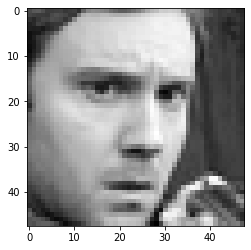

In [7]:
LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

In [8]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [12]:
callback = CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)
model_save = tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True)

In [13]:
# model 선언 
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

# model.compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

#model.fit
model.fit(np.stack(train_x),
          tf.keras.utils.to_categorical(train_y),
          epochs=120,
          batch_size=512,
          validation_data=(np.stack(eval_x),
                           tf.keras.utils.to_categorical(eval_y)),callbacks=[callback,model_save])

Epoch 1/120
64/64 [==============================] - 9s 134ms/step - loss: 2.1809 - categorical_accuracy: 0.2347 - val_loss: 1.8962 - val_categorical_accuracy: 0.1159
Epoch 2/120
64/64 [==============================] - 8s 125ms/step - loss: 1.7288 - categorical_accuracy: 0.3038 - val_loss: 1.8744 - val_categorical_accuracy: 0.1655
Epoch 3/120
64/64 [==============================] - 8s 119ms/step - loss: 1.6005 - categorical_accuracy: 0.3669 - val_loss: 2.0797 - val_categorical_accuracy: 0.1655
Epoch 4/120
64/64 [==============================] - 8s 120ms/step - loss: 1.5269 - categorical_accuracy: 0.4066 - val_loss: 2.2104 - val_categorical_accuracy: 0.1655
Epoch 5/120
64/64 [==============================] - 8s 121ms/step - loss: 1.4742 - categorical_accuracy: 0.4316 - val_loss: 2.3260 - val_categorical_accuracy: 0.1655
Epoch 6/120
64/64 [==============================] - 8s 121ms/step - loss: 1.4468 - categorical_accuracy: 0.4429 - val_loss: 2.3285 - val_categorical_accuracy: 0.165

In [15]:
model2 = tf.keras.models.load_model('model.h5')